# U-Net Segmentation
# Paweł Kolendo

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2022-11-25 20:04:48--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2022-11-25 20:04:49--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz.2’

images.tar.gz.2     100%[===================>] 755.23M  22.5MB/s    in 35s     

2022-11-25 20:05:25 (21.4 MB/s) - ‘images.tar.gz.2’ saved [791918971/791918971]

--2022-11-25 20:05:25--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotation

## Image paths

In [ ]:
#TODO Ustaw niezbędne ścieżki
# wybierz parametry zależnie od możliwości sprzętowych
# sprawdź czy dane pobrały się poprawnie.
 
import os
input_dir = "images"
target_dir = "annotations/trimaps"
img_size = (160, 160)
num_classes = 3
batch_size = 64
input_img_paths = sorted([os.path.join(input_dir,file) for file in os.listdir(input_dir) if file.endswith(".jpg")])
target_img_paths = sorted([os.path.join(target_dir,file) for file in os.listdir(target_dir) if file.endswith(".png") and not file.startswith(".")])

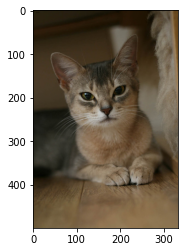

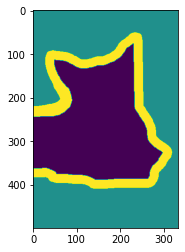

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

cat=cv2.imread(input_img_paths[52])
cat=cv2.cvtColor(cat, cv2.COLOR_BGR2RGB)
plt.imshow(cat)
plt.show()

mask=cv2.imread(target_img_paths[52], cv2.IMREAD_GRAYSCALE)
plt.imshow(mask*50)
plt.show()

## UNet model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

import tensorflow as tf
def get_model(img_size, num_classes):
    inputs = layers.Input(shape=(*img_size, 3))
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    bottleneck = double_conv_block(p4, 1024)
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    outputs = layers.Conv2D(num_classes, 1, padding="same", activation="softmax")(u9)
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model
keras.backend.clear_session()
model = get_model(img_size, num_classes)
print(model.summary())

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 160, 160, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

## Learning model

In [ ]:
#TODO Aby nasza własna funkcja działa jak generator i mogła być używana np. przez fit musi mieć trzy definicje: init, len i getitem
from sklearn.model_selection import train_test_split

class DataGen(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size=batch_size
        self.img_size=img_size
        self.input_img_paths=input_img_paths
        self.target_img_paths=target_img_paths
 
    def __len__(self):
        return int(np.ceil(len(self.input_img_paths)/self.batch_size))
 
    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        start=idx*self.batch_size
        end=min(start+batch_size,len(self.input_img_paths))

        x=[]
        y=[]
        for i in range(start,end):
            image=cv2.imread(self.input_img_paths[i])
            if image is not None:
              image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
              mask=cv2.imread(self.target_img_paths[i])
              x.append(cv2.resize(image,self.img_size))
              y.append(cv2.resize(mask[:,:,1]-1,self.img_size))
        
        x=np.array(x,dtype="float32")
        y=np.array(y,dtype="uint8")
        y=np.expand_dims(y, 3)
        
        return x, y

train_data, val_data,train_labels,val_labels= train_test_split(input_img_paths, target_img_paths, test_size=0.3, random_state=42)

train_gen = DataGen(batch_size, img_size, train_data, train_labels)
val_gen = DataGen(batch_size, img_size, val_data, val_labels)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
model.fit(train_gen,epochs=15,validation_data=val_gen)

Epoch 1/15
81/81 [==============================] - 178s 2s/step - loss: 4.2072 - val_loss: 0.8937
Epoch 2/15
81/81 [==============================] - 126s 2s/step - loss: 0.7988 - val_loss: 0.7155
Epoch 3/15
81/81 [==============================] - 126s 2s/step - loss: 0.6955 - val_loss: 0.6636
Epoch 4/15
81/81 [==============================] - 127s 2s/step - loss: 0.6357 - val_loss: 0.5735
Epoch 5/15
81/81 [==============================] - 126s 2s/step - loss: 0.5970 - val_loss: 0.5550
Epoch 6/15
81/81 [==============================] - 126s 2s/step - loss: 0.5756 - val_loss: 0.5491
Epoch 7/15
81/81 [==============================] - 126s 2s/step - loss: 0.5322 - val_loss: 0.4979
Epoch 8/15
81/81 [==============================] - 126s 2s/step - loss: 0.4983 - val_loss: 0.4734
Epoch 9/15
81/81 [==============================] - 126s 2s/step - loss: 0.4751 - val_loss: 0.4707
Epoch 10/15
81/81 [==============================] - 126s 2s/step - loss: 0.4643 - val_loss: 0.4513
Epoch 11/

## Testing on image that model has not seen

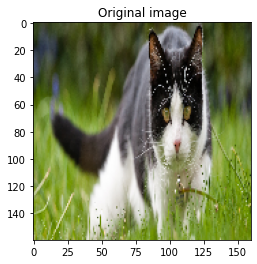

1/1 [==============================] - 0s 304ms/step


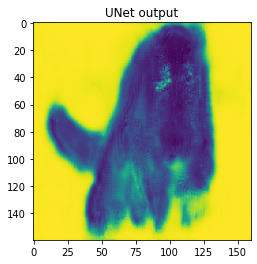

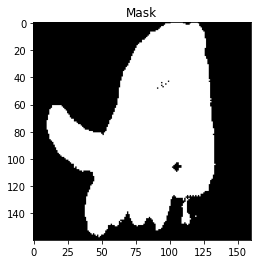

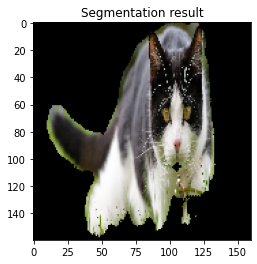

In [ ]:
from keras import models

cattest=cv2.imread('cattest.jpg')
cattest=cv2.cvtColor(cattest, cv2.COLOR_BGR2RGB)
cattest=cv2.resize(cattest,img_size)
plt.imshow(cattest)
plt.title("Original image")
plt.show()

layer_outputs = [layer.output for layer in model.layers]
activation_model = models.Model(model.input, layer_outputs)
activations = activation_model.predict(cattest.reshape(1,img_size[0],img_size[1],3))
output=activations[-1][0,:,:,1]
plt.imshow(output)
plt.title("UNet output")
plt.show()

bin=np.where(output<0.7,1,0)
plt.imshow(bin.astype('uint8')*255,cmap='gray')
plt.title("Mask")
plt.show()

plt.imshow(cattest*np.repeat(bin[:,:,np.newaxis],3,axis=2))
plt.title("Segmentation result")
plt.show()